# First read in the read lengths for the Ashkenazi data

In [1]:
ashkenazi_rc = [int(l.strip()) for l in open('ashkenazi_rc.csv')]

In [2]:
sum(ashkenazi_rc)

219010844467

In [3]:
nc358_size = 2272400000

# Calculate the size of this data in terms of the Maize genome

In [4]:
coverage = sum(ashkenazi_rc) / float(nc358_size)
print coverage

96.3786500911


In [5]:
target_coverage = 50.0

In [6]:
downsample_ratio = target_coverage/ coverage
print downsample_ratio

0.518787096029


# Now downsample the reads to have the target read length distribution

In [7]:
import numpy as np

In [8]:
maize_target_distribution = [r for r in ashkenazi_rc if np.random.uniform() < downsample_ratio]

In [9]:
sum(maize_target_distribution) / float(nc358_size)

50.00269271563105

# Load the maize distribution

In [10]:
maize_starting_distribution = [int(l.strip()) for l in open('maize_raw_rc.csv')]

In [11]:
maize_starting_coverage = sum(maize_starting_distribution) / float(nc358_size)
print maize_starting_coverage

75.2881381438


In [12]:
print len(maize_starting_distribution)
print len(maize_target_distribution)

22342330
13809742


### Note that our target distribution has more reads than all of our starting data.  This means that we won't quite get the coverage we hoped for.

In [13]:
maize_target_distribution_modified = maize_target_distribution[:len(maize_starting_distribution)]
print sum(maize_target_distribution_modified) / float(nc358_size)

50.0026927156


### That's pretty close though!

# Let's make some helper functions

In [14]:
from matplotlib import pyplot as plt

In [15]:
%matplotlib inline

In [16]:
def calc_pdf(data):
    max_val = max(data)
    total = sum(data)
    prob = np.zeros(max_val+1)
    
    for d in data:
        prob[d] += 1
    
    prob = [p/float(total) for p in prob]
    
    return prob

In [17]:
def calc_cumsum(data):
    total = sum(data)
    data = sorted(data)
    data = np.cumsum(data)
    data = [d/float(total) for d in data]
    
    return data

In [18]:
def calc_n50(data):
    data = sorted(data)
    total = sum(data)
    norm_data = np.cumsum(data) / float(total)
    idx = np.searchsorted(norm_data, 0.5)
    
    return data[idx]

# And do a sanity check to ensure that the distributions are the same

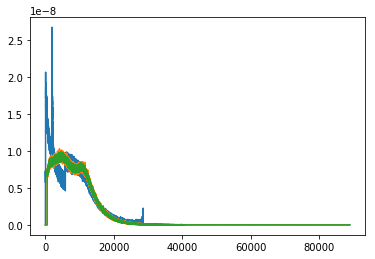

In [19]:
plt.plot(calc_pdf(maize_starting_distribution), label='Maize starting')
plt.plot(calc_pdf(maize_target_distribution), label='Maize target')
plt.plot(calc_pdf(ashkenazi_rc), label='Ashkenazi')

In [20]:
print len(maize_starting_distribution)
print len(maize_target_distribution)

22342330
13809742


## Interesting, it looks like we have fewer reads in all of the maize data than our downsampled target distribution
Let's see what the coverage is if we were to use the same number of reads

In [21]:
print sum(maize_target_distribution[:len(maize_starting_distribution)]) / float(nc358_size)

50.0026927156


## O.K., I think this probably will work
We'll plan on actually trimming the reads that we have rather than just down-sample.

In [22]:
maize_starting_sorted_with_index = sorted(zip(maize_starting_distribution, xrange(len(maize_starting_distribution))), key=lambda x: x[0], reverse=True)
maize_target_distribution_sorted = sorted(maize_target_distribution[:len(maize_starting_distribution)], reverse=True)

In [23]:
from itertools import izip

In [24]:
maize_new_distribution = []
for maize, target in izip(maize_starting_sorted_with_index, maize_target_distribution_sorted):
    if maize[0] > target:
        maize_new_distribution.append((target, maize[1]))
    else:
        maize_new_distribution.append(maize)

In [25]:
new_maize_dist = [r[0] for r in maize_new_distribution]
print sum(new_maize_dist) / float(nc358_size)

50.0025082899


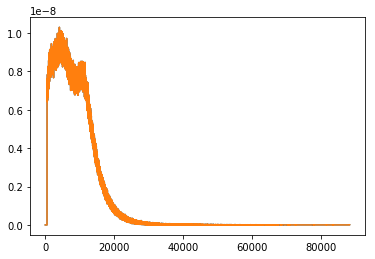

In [26]:
plt.plot(calc_pdf(new_maize_dist))
plt.plot(calc_pdf(maize_target_distribution_sorted))
#plt.plot(calc_pdf(maize_starting_distribution))

In [28]:
print calc_n50(new_maize_dist)
print calc_n50(maize_target_distribution_sorted)
print calc_n50(maize_starting_distribution)

11334
11094
21166


## We matched the distributions pretty well...
Now let's sort the dist back in the proper order

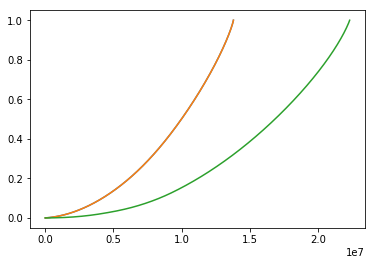

In [31]:
plt.plot(calc_cumsum(new_maize_dist))
plt.plot(calc_cumsum(maize_target_distribution_sorted))
plt.plot(calc_cumsum(maize_starting_distribution))

In [34]:
maize_new_distribution_proper_order = {x[1]: x[0] for x in maize_new_distribution}
#maize_new_distribution_proper_order = sorted(maize_new_distribution, key=lambda x: x[1])

In [35]:
with open('desired_read_lengths.csv', 'w') as fh:
    for i in xrange(len(maize_starting_distribution)):
        fh.write('{0}\n'.format(maize_new_distribution_proper_order.get(i, 0)))